In [134]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

## Technical Indicators

In [135]:
data = pd.read_csv("../datasets/rates_2017_january_may_1min.csv")

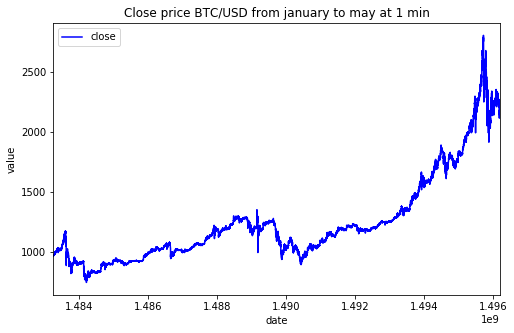

In [136]:
data.plot(style='b',
          figsize=(8,5),
          x='time', 
          y='close', 
          title='Close price BTC/USD from january to may at 1 min',
         )
plt.xlabel('date')
plt.ylabel('value')

In [137]:
## Changing default index to timestamps
data.index = data['time']
data = data.drop('time', axis=1)

In [138]:
data.head()

,low,high,open,close,volume
time,,,,,
1483250400,966.92,967.00,966.92,966.99,0.31111
1483250460,966.70,966.74,966.74,966.70,0.46780
1483250520,966.80,966.98,966.98,966.80,0.61248
1483250580,966.75,966.79,966.79,966.79,0.62527
1483250700,966.81,966.81,966.81,966.81,0.23379


In [139]:
## Define an interval to plot
interv = (data.index > 1488040000) &   (data.index < 1488045000)

In [140]:
## Define some functions
def rsi(window, prices):
    delta = prices.diff()
    dUp, dDown = delta.copy(), delta.copy()
    dUp[dUp < 0] = 0
    dDown[dDown > 0] = 0
    RolUp = dUp.rolling(window=window, center=False).mean()
    RolDown = dDown.rolling(window=window, center=False).mean().abs()
    RS = RolUp / RolDown
    rsi = 100 - (100 / (1 + RS))
    return rsi

def daily_returns(prices):
    """Compute and return the daily return values."""
    daily_returns = prices.copy() # copy given Serie to match size 
    # compute daily returns for row 1 onwards
    daily_returns[1:] = (prices[1:] / prices[:-1].values)-1
    daily_returns.iloc[0] = 0 # set daily returns for row 0 to 0
    return daily_returns

def discretizer(data, steps):
    data = data.copy()
    stepsize = len(data) / steps
    data.sort()
    threshold = [0 for i in range(steps)]
    for i in range(0, steps):
        threshold[i] = data[(i+1) * stepsize -1]
    return lambda(x): np.sum([x > i for i in threshold])

In [141]:
## Compute indicators
data['sma5'] = data['close'].rolling(window=5, center=False).mean()
data['sma10'] = data['close'].rolling(window=10, center=False).mean()
data['bb_upper_10'] = data['sma10'] + 2* data['close'].rolling(window=10, center=False).std()
data['bb_lower_10'] = data['sma10'] - 2* data['close'].rolling(window=10, center=False).std()
data['sma5_norm'] = data['sma5'] / data['close'] -1
data['sma10_norm'] = data['sma10'] / data['close'] -1
data['bbvalue'] = (data['close'] - data['sma10']) / (2 * data['close'].rolling(window=10, center=False).std())
data['rsi9'] = rsi(9, data['close'])
data['rsi14'] = rsi(14, data['close'])

### SMA 5 & 10 Normalized

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f38ae53f190>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f38ae457110>], dtype=object)

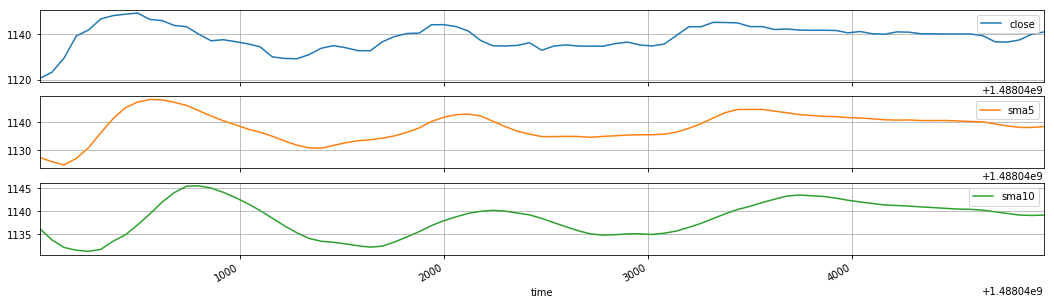

In [142]:
to_plot = data[['close', 'sma5', 'sma10']][interv]
to_plot.plot(figsize=(18,5), grid=True, subplots=True)

### Bollinger Band value

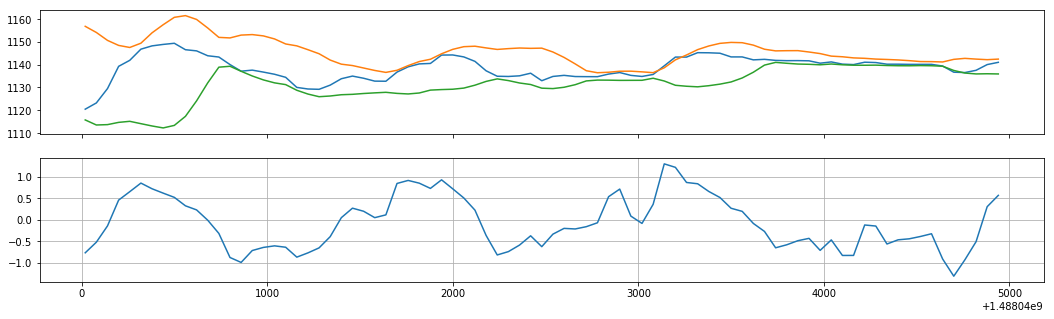

In [143]:
f, axarr = plt.subplots(2, sharex=True, figsize=(18,5))
plt.grid()
axarr[0].plot(data[['close', 'bb_upper_10', 'bb_lower_10']][interv])
axarr[1].plot(data['bbvalue'][interv])

### Relative Strength Index 9 & 14

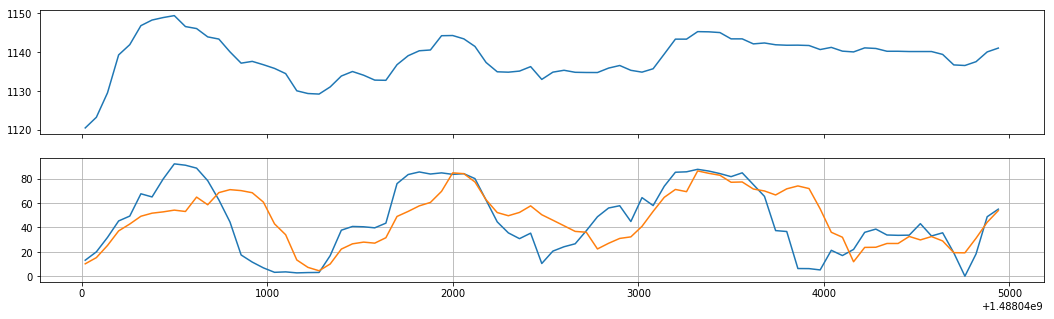

In [144]:
f, axarr = plt.subplots(2, sharex=True, figsize=(18,5))
plt.grid()
axarr[0].plot(data['close'][interv])
axarr[1].plot(data[['rsi9', 'rsi14']][interv])

## Reward

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f38a8a17210>], dtype=object)

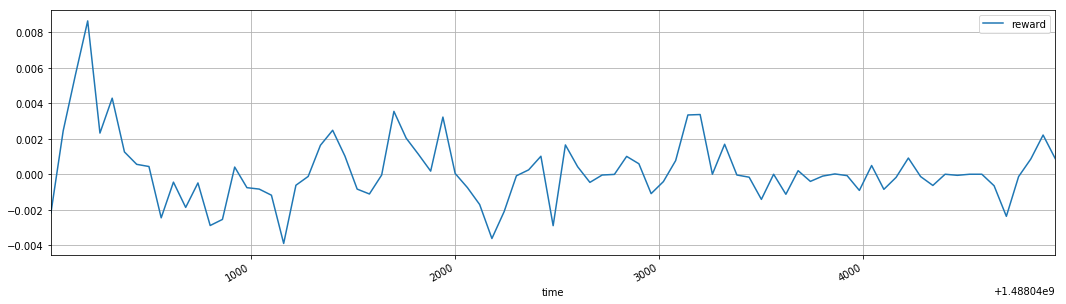

In [145]:
data['reward'] = daily_returns(data['close'])
to_plot = data[['reward']][interv]
to_plot.plot(figsize=(18,5), grid=True, subplots=True)

In [146]:
data['reward'].describe()

count    195814.000000
mean          0.000005
std           0.001330
min          -0.114286
25%          -0.000122
50%           0.000000
75%           0.000216
max           0.077566
Name: reward, dtype: float64

## States 

In [147]:
## Build disretizers
d_sma5 = discretizer(data['sma5'].values, 10)
d_sma10 = discretizer(data['sma10'].values, 10)
d_bbvalue = discretizer(data['bbvalue'].values, 10)
d_rsi9 = discretizer(data['rsi9'].values, 10)
d_rsi14 = discretizer(data['rsi14'].values, 10)

In [148]:
## Discretize indicators
data['sma5_discrete'] = data["sma5"].apply(d_sma5)
data['sma10_discrete'] = data["sma10"].apply(d_sma10)
data['bbvalue_discrete'] = data["bbvalue"].apply(d_bbvalue)
data['rsi9_discrete'] = data["rsi9"].apply(d_bbvalue)
data['rsi14_discrete'] = data["rsi14"].apply(d_bbvalue)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f38ade97310>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f38adc32d50>], dtype=object)

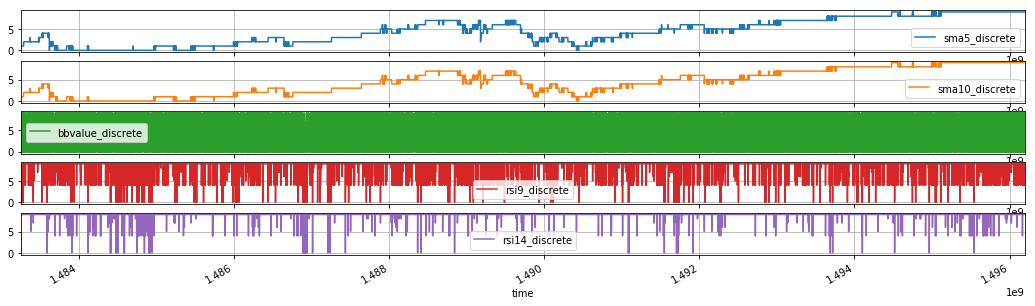

In [149]:
## Plot discretized indicators individualy 
to_plot = data[['sma5_discrete', 'sma10_discrete', 'bbvalue_discrete', 'rsi9_discrete', 'rsi14_discrete']]
to_plot.plot(figsize=(18,5), grid=True, subplots=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f38a8185250>], dtype=object)

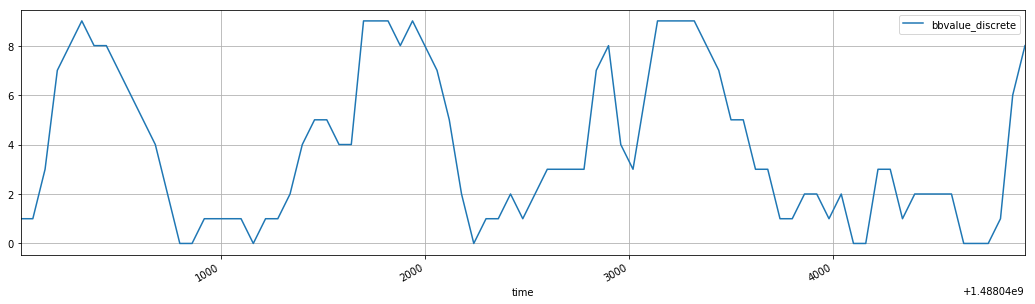

In [151]:
to_plot = data[['bbvalue_discrete']][interv]
to_plot.plot(figsize=(18,5), grid=True, subplots=True)

In [156]:
### Compute global states
data['state'] = data['sma5_discrete']*10000 + \
                data['sma10_discrete']*1000 + \
                data['bbvalue_discrete']*100 + \
                data['rsi9_discrete']*10 + \
                data['rsi14_discrete']

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f38ab0a63d0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f38ab02cf90>], dtype=object)

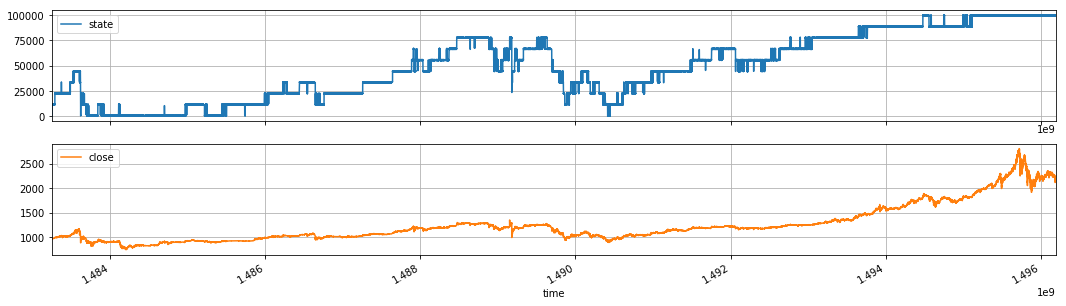

In [161]:
to_plot = data[['state', 'close']]
to_plot.plot(figsize=(18,5), grid=True, subplots=True)